In [1]:
import scipy.io as spio
import numpy as np
import math
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from collections import Counter
from sklearn import preprocessing


In [2]:
def readMat(dataPath):
    
    
    #readMat: Reads the .mat for mad river data files placed at data path
    #INPUT
    #dataPath == relative location of the data path to the code file, or absolute
    #
    #OUTPUT
    #still being worked on
    #eventToClass== np array of all classes belonging to all 616events. value at 0 index is class for 0th event.
    #sedimentData_events == list containing array for sediment data for each event
    #
    #
    #events == list containing 2-D array for each event. 1st column is sediment and 2nd is stream flow. Ideally we will be using this
    #maxEventLen == Longest event in terms of timesteps
    
    #sample call: eventToClass, myEvents, maxEventLen,streamFlow_Data,sedimentData_events = readMat('..\data\')
    
    #Programmer: Ali Javed
    #Date last modified: 27 Feb 2018
    #modified by: Ali Javed
    #Comments: Initial version.
    
    
    ##############################################################################################################
        
    
    
    
    classMat = spio.loadmat(dataPath + 'allMadSitesStormHystClassKey.mat', squeeze_me=True)
    dataMat = spio.loadmat(dataPath + 'allMadSitesEventTimeSeries.mat', squeeze_me=True)
    
    eventToClass = classMat['stormHystClass'][:,3] #index 3 refers to class of 3rd event. Event number start from 0
    eventToClass = eventToClass.astype(int) # we do not need float classes




    #gather 626 events
    events = []
    sedimentData_events = []
    streamFlowData_events = []
    counter = 0
    maxEventLen = -1 #need this as fixed size input to keras RNN
    
    streamFlow = 1
    suspendedSedimentConcentration = 2
    
    for event in range(0,len(dataMat['dataTSOut'])):
    
    
        #not reading datetime and rainfall data for now
        #event_dataTime = np.zeros((len(dataMat['dataTSOut'][event][streamFlow]))) #can not extract datetime so setting it to one, for out purpose it does not matter anyways
        #event_rainFall = np.zeros((len(dataMat['dataTSOut'][event][streamFlow])))
                             
        event_streamflow = dataMat['dataTSOut'][event][streamFlow]
        event_suspendedSedimentConcentration = dataMat['dataTSOut'][event][suspendedSedimentConcentration]
    
        
        eventArray = np.column_stack((event_streamflow,event_suspendedSedimentConcentration))
        
        
        events.append(eventArray)
        sedimentData_events.append(event_streamflow)
        streamFlowData_events.append(event_suspendedSedimentConcentration)
    
        if len(event_streamflow)> maxEventLen:
            maxEventLen = len(event_streamflow)
    
    
        
        ##############################################################################################################
        #for classification based only on rain and sediment... i can not figure out how to give 2d input to RNN
        
        
        #classVector = np.repeat(eventToClass[event], len(event_streamflow))
        #print(np.shape(classVector))
        #print(np.shape(suspendedSedimentConcentration))
        #streamFlow_Data = np.column_stack((event_streamflow,classVector))
        #suspendedSedimentConcentration_Data = np.column_stack((event_suspendedSedimentConcentration,classVector))
        
    return eventToClass, events, maxEventLen, streamFlowData_events, sedimentData_events
    
    
 ##############################################################################################################
       

 



 
    


In [3]:

def readCharMat(dataPath):


    dataMat = spio.loadmat(dataPath + 'mixoutALL_shifted.mat', squeeze_me=True)
    classMat = spio.loadmat(dataPath +'char_class_labels',squeeze_me=True)  
    eventToClass = classMat['y_data']

    #gather 626 events
    events = []
    sedimentData_events = []
    streamFlowData_events = []

    maxEventLen = -1 #need this as fixed size input to keras RNN

    streamFlow = 1
    suspendedSedimentConcentration = 2

    for event in range(0,len(dataMat['mixout'])):


            event_streamflow = dataMat['mixout'][event][streamFlow]
            event_suspendedSedimentConcentration = dataMat['mixout'][event][suspendedSedimentConcentration]


            eventArray = np.column_stack((event_streamflow,event_suspendedSedimentConcentration))


            events.append(eventArray)
            sedimentData_events.append(event_streamflow)
            streamFlowData_events.append(event_suspendedSedimentConcentration)

            if len(event_streamflow)> maxEventLen:
                maxEventLen = len(event_streamflow)


    return eventToClass, events, maxEventLen, streamFlowData_events, sedimentData_events
 
    



In [4]:
dataPath = '../data/'

#eventToClass as an array of len(events) with each index telling the class of event
#myEvents is a list containing 2-d arrays for all events. 0 column is the stream flow, 1 column is sediment concentration
eventToClass, myEvents, maxEventLen,streamFlow_Data,sedimentData_events = readMat(dataPath)
#eventToClass, myEvents, maxEventLen,streamFlow_Data,sedimentData_events = readCharMat(dataPath)



In [15]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
# fix random seed for reproducibility
numpy.random.seed(7)



In [6]:
#append two arrays into single for each even, apparantely it doesnt matter what order data is passed to NN for 2 d events, as long as format is consitent
#i.e first 20 rows for sediment rate, next 20 for rain
'''
rain_sediment = []
for i in range(0,len(sedimentData_events)):
    t1 = sedimentData_events[i]
    t2 = streamFlow_Data[i]
    
    rain_sediment_event = np.append(t1,t2)
    rain_sediment.append(rain_sediment_event)
'''
    
rain_sediment = []
for i in range(0,len(sedimentData_events)):    
    t1 = sedimentData_events[i]
    t2 = streamFlow_Data[i]
    #t1 = preprocessing.normalize(t1)
    #t2 = preprocessing.normalize(t2)
    t1 = preprocessing.scale(t1)
    t2 = preprocessing.scale(t2)
    
    rain_sediment_event = np.column_stack((t1,t2))
    rain_sediment.append(rain_sediment_event)
    

use this parameter length for feature extraction purposes

In [7]:
#maxEventLen = 313


In [8]:
#train test split startified not being done for now

#preprocess data to required format, padding to make all sequence data same lenght
#to use sediment rate onle, replace with sedimentData_events, for stream for data only streamFlow_Data, for both sediment and stream flow rain_sediment 
X_data = sequence.pad_sequences(rain_sediment,dtype='float',maxlen = maxEventLen)
#create one hot representation for class values
y_dataOneHot = to_categorical(eventToClass, num_classes=None)
y_dataCont = eventToClass

In [9]:
for i in range(0,len(X_data)):
    X_data[i] = preprocessing.normalize(X_data[i])

If feature extraction is required use all data. No train test split

In [10]:
X_train = X_data
y_trainOneHot = y_dataOneHot
y_trainCont = y_dataCont
    

In [11]:
#Test/Train Split
'''
sampler = StratifiedKFold(n_splits=4, shuffle=False, random_state=None)
#sampler.split(x= X_data,y=eventToClass)

for train_index, test_index in sampler.split(X_data, eventToClass):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_trainOneHot, y_testOneHot = y_dataOneHot[train_index], y_dataOneHot[test_index]
    y_trainCont, y_testCont = y_dataCont[train_index], y_dataCont[test_index]
'''   

'\nsampler = StratifiedKFold(n_splits=4, shuffle=False, random_state=None)\n#sampler.split(x= X_data,y=eventToClass)\n\nfor train_index, test_index in sampler.split(X_data, eventToClass):\n    X_train, X_test = X_data[train_index], X_data[test_index]\n    y_trainOneHot, y_testOneHot = y_dataOneHot[train_index], y_dataOneHot[test_index]\n    y_trainCont, y_testCont = y_dataCont[train_index], y_dataCont[test_index]\n'

In [12]:
#############################################################################
#DECLARE PARAMETERS FOR NN
#these parameters are the architecture of the RNN. Still have to do more on this
embedding_vecor_length = 16  #each event is represented using a 32 length vector. 
epochs = 2
batchSize = len(X_train)  #use all data.
maxEventLenPram = maxEventLen
#maxEventLenPram = maxEventLen *2 # if we are passing both rain and sediment in 1 d use multiply maxevent lenght by 2, this is input size if trying only rain or sediment, use maxeventlen
m = np.amax(X_train)+1 #what is the maximum data value
m = round(m)
len_input = int(m)
num_classes = y_trainCont[1]+1
max_value = int(np.amax(X_train)+1)
###############################################################################

In [13]:
X_train = X_train.reshape(len(X_train),maxEventLenPram , 2)
#for feature extration there is no X_test
#X_test = X_test.reshape(len(X_test), maxEventLenPram, 2)

fit data on RNN if needed

RNN for feature extraction

In [24]:
###############################################################################
#CREATE RNN
from keras.layers import Input

# create the model

model = Sequential()


cells = [
    LSTM(100),
    LSTM(100),
    LSTM(100),
]

model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(maxEventLenPram, 2)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
#CHARACTER DATA SET HAS 21 CLASSES
model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



import os.path
if os.path.exists('../history/biDir_LSTM128128_D6464.weights'):
    model.load_weights('../history/biDir_LSTM128128_D6464.weights')
    print('Weights loaded')
else:
    print('FAILED TO LOAD WEIGHTS. DO NOT CONTINUE')
    
    
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 313, 256)          134144    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 21)                1365      
__________

In [25]:
#pops softmax
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 313, 256)          134144    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 21)                1365      
Total para

In [26]:
#pops dense
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 313, 256)          134144    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
Total params: 548,992
Trainable params: 548,992
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.models import Model
#enter the name of last dense layer here
layer_name = 'dense_15'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [ ]:
#just see how discriminating the features are
sum(intermediate_output[7])

In [ ]:
np.shape(intermediate_output)


In [ ]:
path = '../features/biDir_LSTM128128_D6464.features'
np.save(path,intermediate_output)

In [33]:
#load history object for training of character dataset
import pickle        
path = '../history/biDir_LSTM128128_D6464.his'
history = pickle.load( open( path, "rb" ) )


{'acc': [0.032977242022752762,
  0.056665118783712387,
  0.066418953239917755,
  0.067347884178161621,
  0.068741291761398315,
  0.063167676329612732,
  0.064561076462268829,
  0.069670230150222778,
  0.075708314776420593,
  0.10543427616357803,
  0.095215976238250732,
  0.096144914627075195,
  0.095680445432662964,
  0.098002783954143524,
  0.10404087603092194,
  0.11193682998418808,
  0.12494194507598877,
  0.12215512990951538,
  0.13051556050777435,
  0.14770087599754333,
  0.15791918337345123,
  0.14955875277519226,
  0.1458430141210556,
  0.13887599110603333,
  0.14816534519195557,
  0.16674408316612244,
  0.14816534519195557,
  0.17649790644645691,
  0.17231769859790802,
  0.1690664142370224,
  0.17278216779232025,
  0.17882025241851807,
  0.17417557537555695,
  0.18253599107265472,
  0.18207152187824249,
  0.19321876764297485,
  0.20065025985240936,
  0.18903854489326477,
  0.19554109871387482,
  0.21830004453659058,
  0.2113330215215683,
  0.2215513288974762,
  0.20483046770095

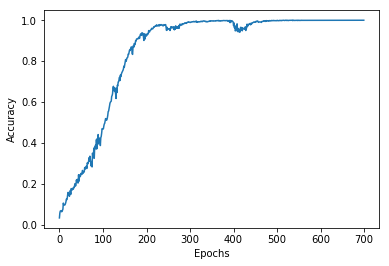

In [36]:

import matplotlib.pyplot as plt
plt.plot(history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('../figures/Accuracy')
plt.show()

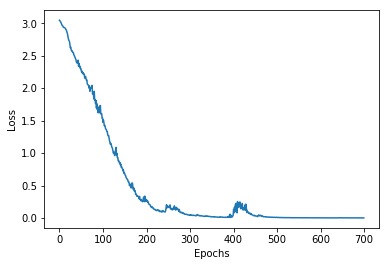

In [37]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('../figures/loss')
plt.show()